# Particles Simulations

In [81]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.special import iv
from tqdm import trange

class ParticlesSimulation:
    def __init__(
        self, 
        dtype: torch.dtype, 
        device: torch.device, 
        T: float = 1.0, 
        beta: float = 4.0, 
        dt: float = 1e-4, 
        N: int = 10**4
    ):
        """
        Initialize the particle simulation.

        Parameters:
        - dtype: Data type for tensor computations.
        - device: Device to run the simulation on (e.g., 'cpu' or 'cuda').
        - T: Total time of the simulation.
        - beta: temperature parameter.
        - dt: Time step for numerical integration.
        - N: Number of particles.
        """
        self.T = T
        self.beta = beta
        self.dt = dt
        self.N = N
        self.timesteps = torch.arange(0, T / dt + 1) * dt
        self.device = device
        self.dtype = dtype

        # Generate N i.i.d. initial conditions with N particles
        self.theta0 = torch.rand(N, device=self.device, dtype=self.dtype) * 2 * np.pi

    def get_initial_fourier(self, k):
        """
        Calculate the initial Fourier coefficient for mode k.

        Parameters:
        - k: Fourier mode

        Returns:
        - Fourier coefficient for mode k
        """
        return (1 / self.N) * torch.sum(torch.exp(-1j * k * self.theta0))
  
    def g_coeff(self, x):
        """
        Compute the \gamma_k coefficients.

        Parameters:
        - x: Input value

        Returns:
        - g coefficient
        """
        return (x**2 * iv(x, self.beta)) / (np.pi * self.beta)
      
    def K(self, theta: torch.Tensor) -> torch.Tensor:
        """
        Kernel function for pairwise interactions.

        Parameters:
        - theta: Angular distance between particles

        Returns:
        - Kernel value for the given angular distance
        """
        return torch.exp(self.beta * torch.cos(theta)) * torch.sin(theta)
    
    def F(self, theta: torch.Tensor) -> torch.Tensor:
        """
        Compute the force acting on each particle.

        Parameters:
        - theta: Current particle positions

        Returns:
        - Force vector for each particle
        """
        delta_theta_ij = theta[:, None] - theta[None, :]  # Pairwise distances
        K_theta_ij = self.K(delta_theta_ij)
        dtheta_i = -1 / self.N * torch.sum(K_theta_ij, dim=-1)
        return dtheta_i

    def run(self) -> torch.Tensor:
        """
        Run the particle simulation.

        Returns:
        - Trajectories of all particles over time
        """
        theta_t = self.theta0.clone()
        trajectories = torch.zeros(
            len(self.timesteps), self.N, device=self.device, dtype=self.dtype
        )
        trajectories[0, :] = theta_t
        
        for i in trange(0, len(self.timesteps) - 1, desc="Simulating"):
            theta_t = theta_t + self.dt * self.F(theta_t)
            trajectories[i + 1, :] = theta_t
        
        return trajectories

## Beta = 5

In [82]:
torch.manual_seed(12345)
device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the simulation
sim = ParticlesSimulation(dtype = torch.double,
                           device = device,
                           beta = 5, 
                           T = 0.6, 
                           dt = 1e-4, 
                           N = 2*10**4)

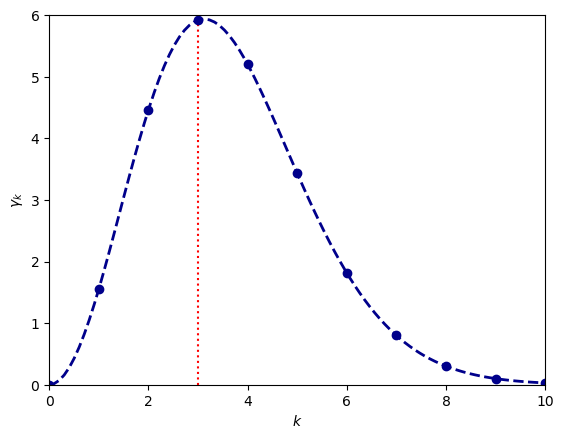

In [83]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Plot of the \gamma_k
x = np.arange(0, 11)
x_continuous = np.linspace(0, 10, 100)

plt.axvline(x = 3, c="r", linestyle="dotted", linewidth=1.5)
plt.plot(xx, sim.g_coeff(xx),"--", linewidth=2, c="darkblue")
plt.plot(x, sim.g_coeff(x), "o", linewidth=2, c="darkblue")

plt.ylabel("$\gamma_k$")
plt.xlabel("$k$")
plt.xlim(0,10)
plt.ylim(0,6)
plt.show()

In [84]:
# Run the simulation
trajectories = sim.run()

Simulating: 100%|██████████| 6000/6000 [01:31<00:00, 65.78it/s]


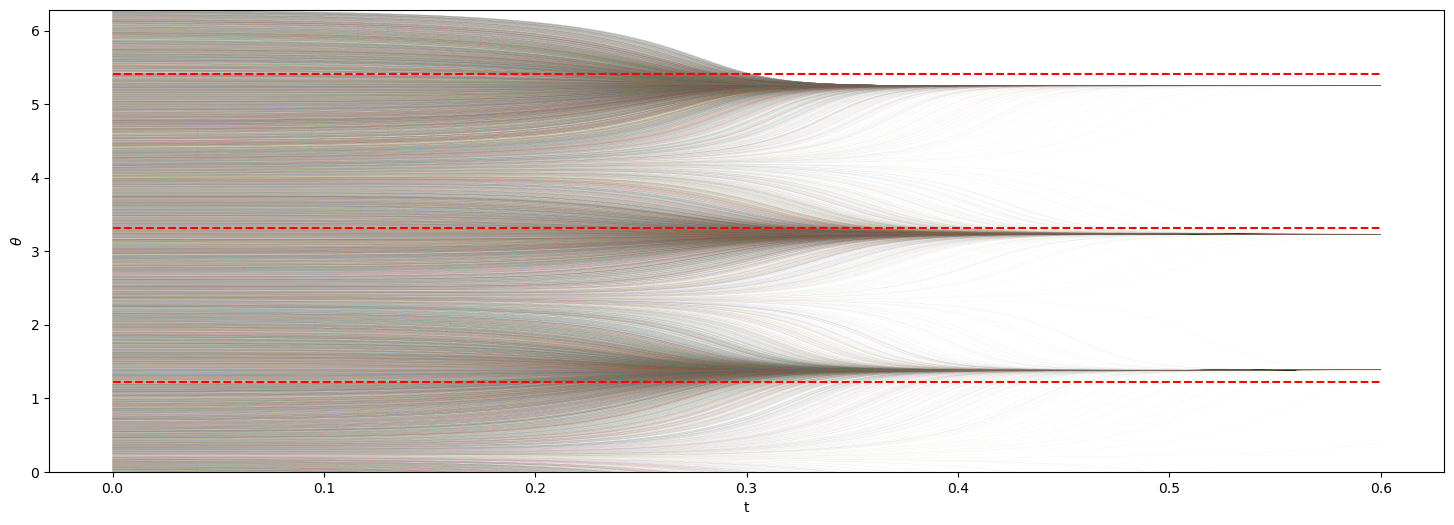

In [85]:
# Compute the predicted position of the clusters
mu_3 = sim.get_initial_fourier(3)
delta_3 = (2*np.pi * torch.arange(0, 3, device=device) - torch.angle(mu_3)) /3 % (2*np.pi)

# Plot the trajectories
fig = plt.figure(figsize = (18,6))

theta_cpu = trajectories.cpu().numpy()
num_steps = 10
for i in range(0, sim.N):
  plt.plot(sim.timesteps[::20], theta_cpu[::20, i], linewidth = 0.05,  alpha=0.3)

plt.hlines(delta_3.cpu(), 0, sim.T, color="r", linestyle="--")

plt.xlabel("t")
plt.ylabel(r"$\theta$")
plt.ylim(0, 2 *np.pi)
plt.show()

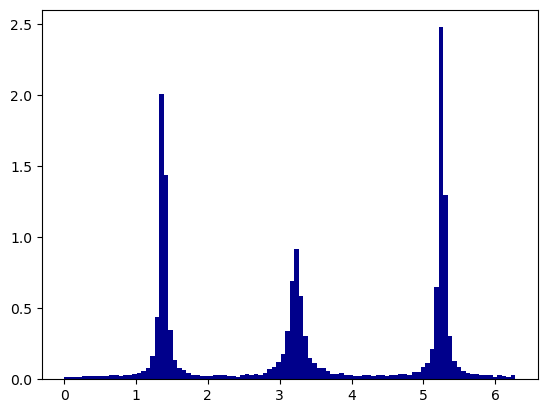

In [86]:
# Plot the histogram of the particles at a given intermediate timestep
idx = 3000
plt.hist(theta_cpu[idx, :] % (2 * np.pi), 
         density=True, 
         bins=100, 
         color="darkblue")
plt.show()

## Beta = 7

In [88]:
torch.manual_seed(1234)
device =  torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the simulation
sim = ParticlesSimulation(dtype=torch.double,
                           device= device,
                           beta=7, 
                           T=0.1, 
                           dt=1e-4, 
                           N=2*10**4)

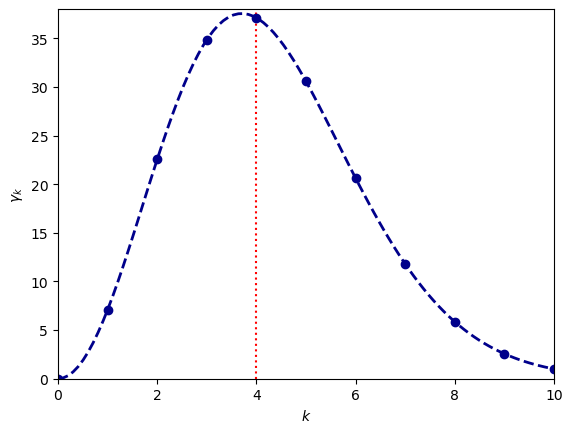

In [89]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Plot of the \gamma_k
x = np.arange(0, 11)
x_continuous = np.linspace(0, 10, 100)

plt.axvline(x = 4, c="r", linestyle="dotted", linewidth=1.5)
plt.plot(xx, sim.g_coeff(xx), "--", linewidth=2, c="darkblue")
plt.plot(x, sim.g_coeff(x), "o", linewidth=2, c="darkblue")

plt.ylabel("$\gamma_k$")
plt.xlabel("$k$")
plt.xlim(0, 10)
plt.ylim(0, 38)
plt.show()

In [90]:
# Run the simulation
trajectories = sim.run()

Simulating: 100%|██████████| 1000/1000 [00:14<00:00, 70.07it/s]


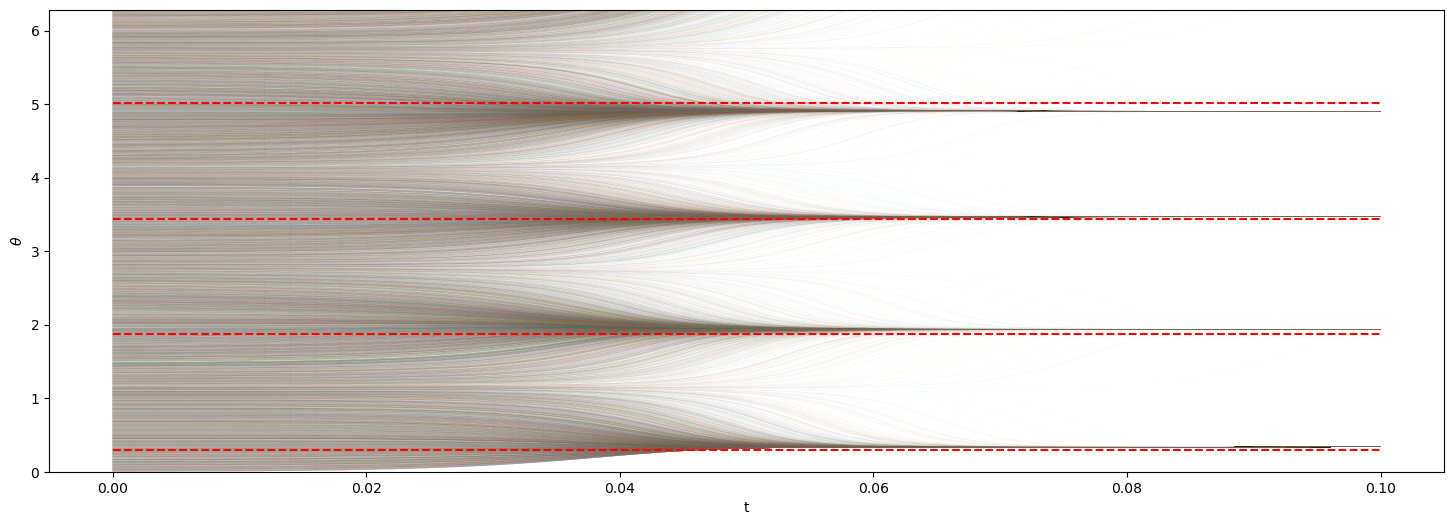

In [91]:
# Compute the predicted position of the clusters
mu_4 = sim.get_initial_fourier(4)
delta_4 = (2*np.pi * torch.arange(0, 4, device=device) - torch.angle(mu_4)) /4 % (2*np.pi)

# Plot the trajectories
fig = plt.figure(figsize = (18,6))

theta_cpu = trajectories.cpu().numpy()
num_steps = 10
for i in range(0, sim.N):
  plt.plot(sim.timesteps[::20], theta_cpu[::20, i], linewidth = 0.05,  alpha=0.3)

plt.hlines(delta_4.cpu(), 0, sim.T, color="r", linestyle="--")

plt.xlabel("t")
plt.ylabel(r"$\theta$")
plt.ylim(0, 2 *np.pi)
plt.show()

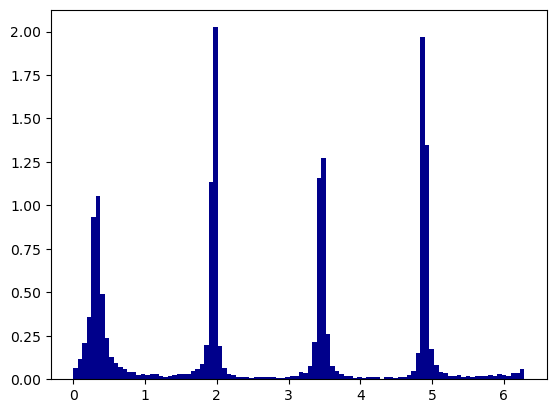

In [96]:
# Plot the histogram of the particles at a given intermediate timestep
idx = 450
plt.hist(theta_cpu[idx, :] % (2 * np.pi), 
         density=True, 
         bins=100, 
         color="darkblue")
plt.show()

# PDE Simulation

In [169]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class PDESimulation:
    def __init__(
        self, 
        n_points: int = 10000, 
        T: float = 0.5, 
        beta: float = 5, 
        plot_interval = 5000,
        sigma = 0.01,
        dtype: torch.dtype = torch.double,
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ):
        """
        Initialize the PDE simulation.

        Parameters:
        - n_points: Number of grid points in spatial domain.
        - T: Total simulation time.
        - beta: Temperature parameter.
        - sigma: Noise intensity.
        - plot_interval: Number of timesteps between each plot.
        - device: Device to run the simulation ('cpu' or 'cuda').
        """
        # Simulation parameters
        self.n_points = n_points
        self.T = T
        self.beta = beta
        self.device = device
        self.plot_interval = plot_interval
        self.sigma = sigma
        self.dtype = dtype
        
        # Spatial grid
        self.X = torch.linspace(0, 2 * np.pi, n_points, dtype=self.dtype)[:-1].to(self.device)
        self.dx = self.X[1] - self.X[0]
        self.dt = 0.02 * self.dx 

        # Temporal grid
        self.num_steps = int(T / self.dt)
        self.U = torch.zeros((self.num_steps, len(self.X)), device=self.device, dtype=self.dtype)

        self.dW = self.compute_interaction().repeat(2).unsqueeze(0).unsqueeze(0) * self.dx

    def initial_u(self, x: torch.Tensor) -> torch.Tensor:
        """
        Generate initial conditions for u.

        Parameters:
        - x: Spatial grid

        Returns:
        - Initial values of u
        """
        return (1 / (2 * np.pi) * torch.ones_like(x) + 
                self.sigma * torch.randn(len(x), device=self.device))

    def compute_interaction(self) -> torch.Tensor:
        """
        Compute the interaction term for the PDE.

        Returns:
        - Interaction term tensor
        """
        return -torch.exp(self.beta * torch.cos(self.X)) * torch.sin(self.X)

    def lax_friedrichs(self, t: int) -> torch.Tensor:
        """
        Implement the Lax-Friedrichs scheme for numerical integration.

        Parameters:
        - t: Current time step

        Returns:
        - Updated values of u for the next time step
        """
        DWu = torch.nn.functional.conv1d(
            self.dW, 
            self.U[t-1].unsqueeze(0).unsqueeze(0), 
            padding="valid"
        )[0, 0, :len(self.X)]

        uDWu = self.U[t-1] * DWu
        
        # Lax-Friedrichs scheme
        uvals = torch.zeros(len(self.X), device=self.device)
        uvals[0] = (
            0.5 * (self.U[t-1][-1] + self.U[t-1][1]) - 
            (self.dt / (2 * self.dx)) * (uDWu[1] - uDWu[-1])
        )
        uvals[1:-1] = (
            0.5 * (self.U[t-1][:-2] + self.U[t-1][2:]) - 
            (self.dt / (2 * self.dx)) * (uDWu[2:] - uDWu[:-2])
        )
        uvals[-1] = (
            0.5 * (self.U[t-1][-2] + self.U[t-1][0]) - 
            (self.dt / (2 * self.dx)) * (uDWu[0] - uDWu[-2])
        )

        return uvals

    def plot_solution(self, uvals: torch.Tensor, t: int) -> None:
        """
        Plot the solution at a given time step.

        Parameters:
        - uvals: Solution values for the current time step
        - t: Current time step
        """
        plt.plot(self.X.cpu(), uvals.cpu(), color='darkblue')
        plt.fill_between(
            self.X.cpu(), uvals.cpu(),
            color='blue', hatch='///',
            alpha=0.4, edgecolor='black'
        )
        plt.ylim(0, 1)
        plt.xlim(0, 2 * np.pi)
        plt.title(f"Solution with beta {self.beta} at time {t * self.dt:.2f}")
        #plt.savefig(f"pde_{t}.png")
        plt.show()

    def run(self) -> torch.Tensor:
        """
        Run the PDE simulation.

        Returns:
        - Simulation results as a tensor of trajectories
        """
        # Initial condition
        self.U[0, :] = self.initial_u(self.X)

        # Plot initial condition
        self.plot_solution(self.U[0, :], t=0)

        # Time integration loop
        for t in tqdm(range(1, self.num_steps), desc="Simulating PDE"):
            self.U[t, :] = self.lax_friedrichs(t)

            # Plot at intervals for visualization
            if t % self.plot_interval == 0:
                self.plot_solution(self.U[t, :], t)
        
        return self.U

## Beta = 5

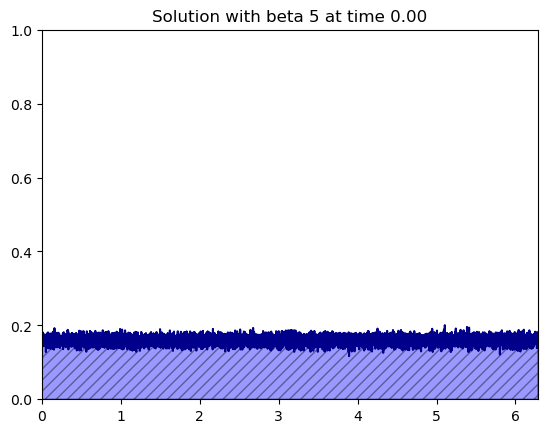

Simulating PDE:  12%|█▏        | 4970/39783 [00:14<01:41, 343.05it/s]

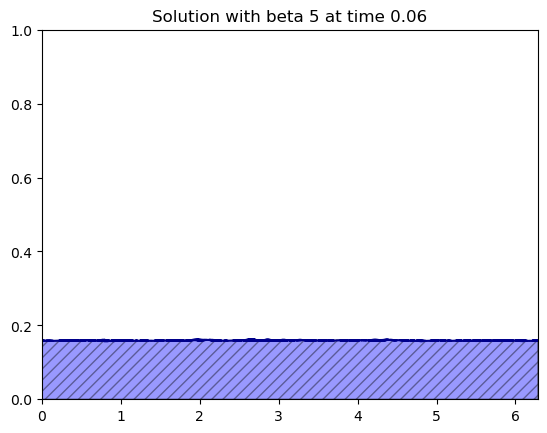

Simulating PDE:  25%|██▌       | 9982/39783 [00:29<01:26, 343.08it/s]

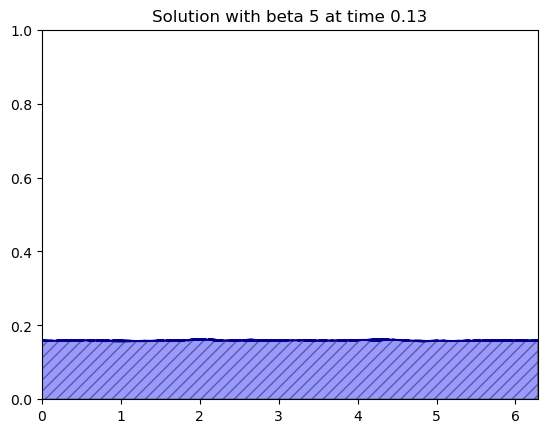

Simulating PDE:  38%|███▊      | 14973/39783 [00:43<01:12, 343.10it/s]

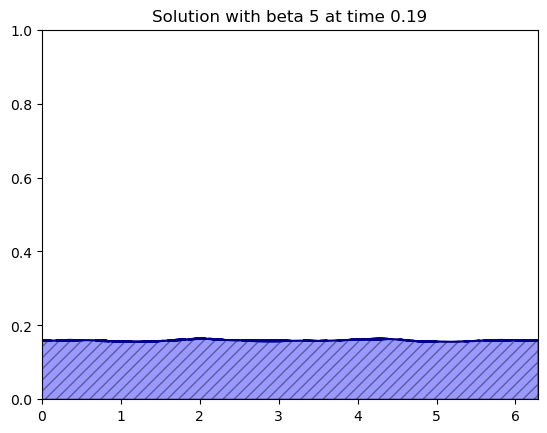

Simulating PDE:  50%|█████     | 19975/39783 [00:59<00:57, 343.05it/s]

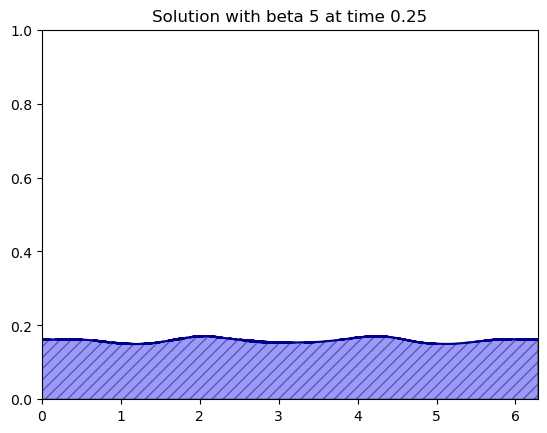

Simulating PDE:  63%|██████▎   | 24978/39783 [01:14<00:43, 343.04it/s]

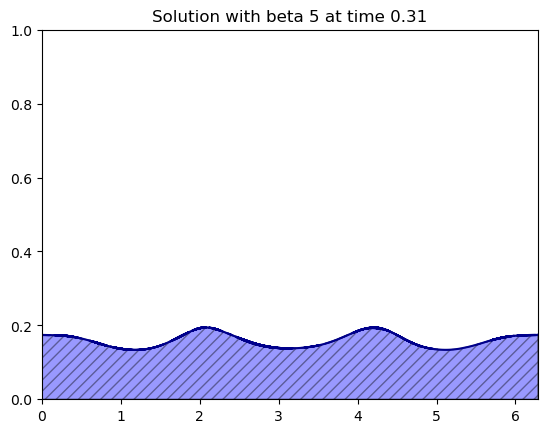

Simulating PDE:  75%|███████▌  | 29976/39783 [01:29<00:28, 343.10it/s]

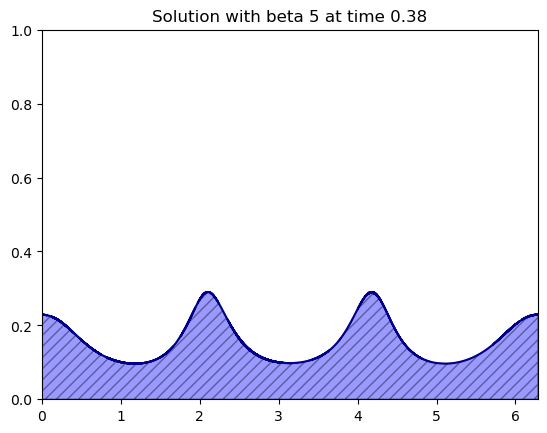

Simulating PDE:  88%|████████▊ | 34977/39783 [01:43<00:14, 343.05it/s]

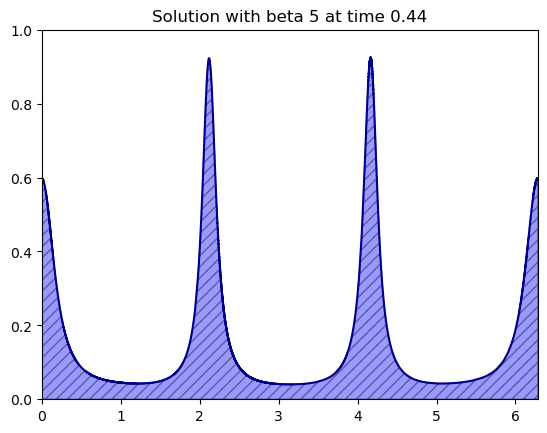

Simulating PDE: 100%|██████████| 39783/39783 [01:58<00:00, 334.66it/s]


In [176]:
# Run the simulation
torch.manual_seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

simulation = PDESimulation(
        n_points=10000, 
        T=0.5, 
        beta=5,
        sigma=0.01,
        plot_interval=5000,
        dtype=torch.double,
        device=device,
)
results = simulation.run()

## Beta = 7

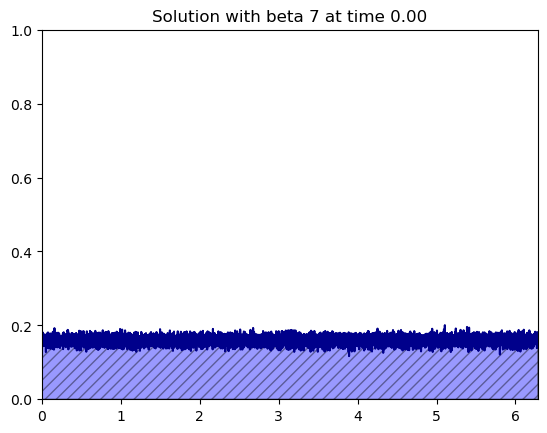

Simulating PDE:  10%|█         | 665/6364 [00:01<00:16, 343.59it/s]

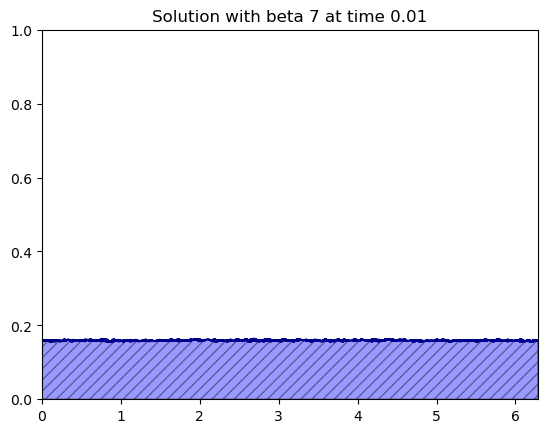

Simulating PDE:  22%|██▏       | 1380/6364 [00:04<00:14, 342.82it/s]

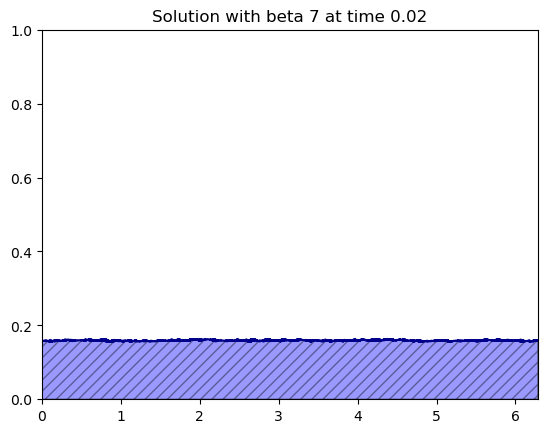

Simulating PDE:  33%|███▎      | 2069/6364 [00:06<00:12, 342.79it/s]

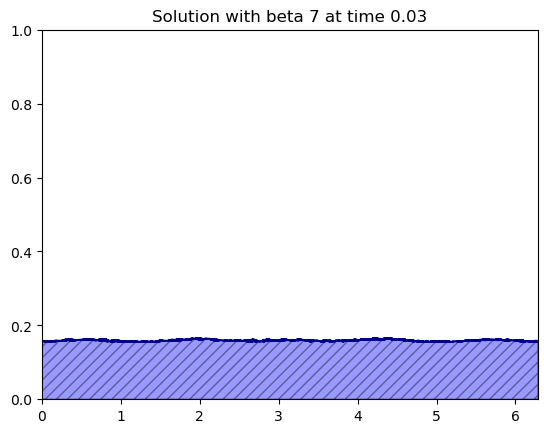

Simulating PDE:  44%|████▎     | 2774/6364 [00:09<00:10, 341.55it/s]

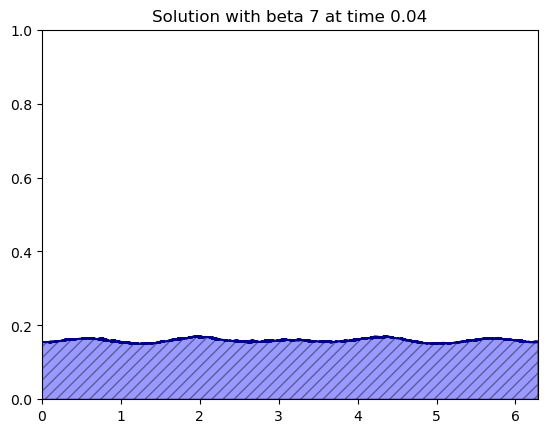

Simulating PDE:  55%|█████▍    | 3474/6364 [00:11<00:08, 342.84it/s]

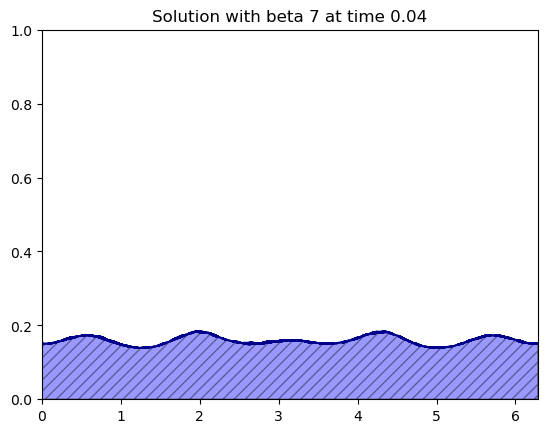

Simulating PDE:  66%|██████▌   | 4174/6364 [00:13<00:06, 342.78it/s]

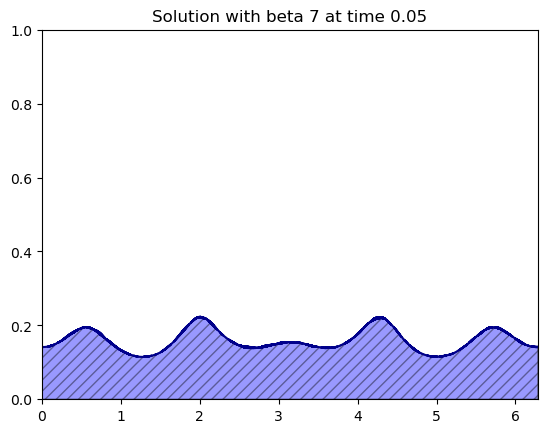

Simulating PDE:  77%|███████▋  | 4874/6364 [00:15<00:04, 342.80it/s]

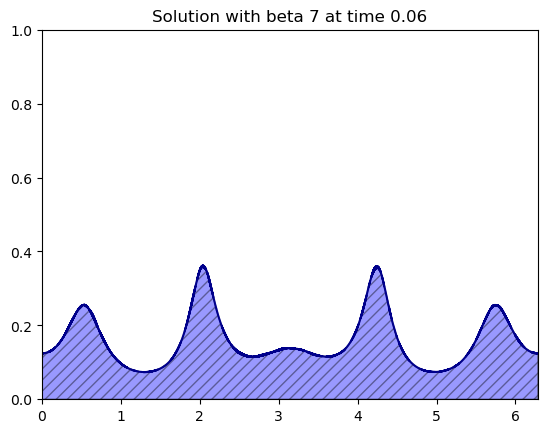

Simulating PDE:  88%|████████▊ | 5574/6364 [00:18<00:02, 342.75it/s]

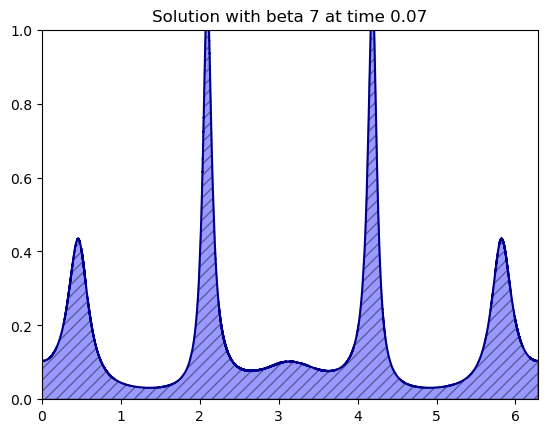

Simulating PDE:  99%|█████████▊| 6269/6364 [00:21<00:00, 341.44it/s]

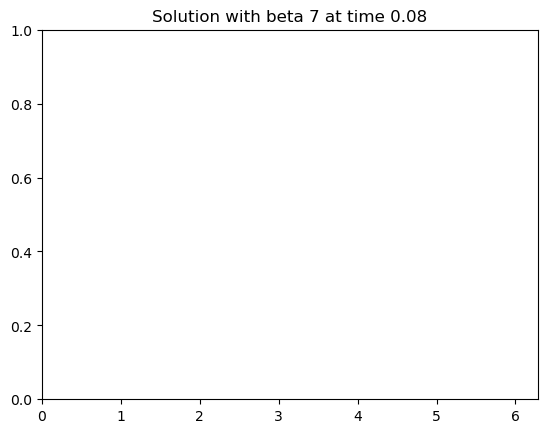

Simulating PDE: 100%|██████████| 6364/6364 [00:21<00:00, 292.23it/s]


In [175]:
# Run the simulation
torch.manual_seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

simulation = PDESimulation(
        n_points=10000, 
        T=0.08, 
        beta=7,
        sigma=0.01,
        plot_interval=700,
        dtype=torch.double,
        device=device,
)
results = simulation.run()